# Notebook 2: Second-Level Analysis


In the last notebook, we performed a first level analysis by using data from a single subject. In this notebook, we will now do a second-level analysis using up to $94$ subjects. 



### Table of Contents

 - [Notebook 0: Introduction](./nb_00_introduction.ipynb)
 - [Notebook 1: FMRI Data and First-Level Analysis](./nb_01_fmri_data_and_first_level_analysis.ipynb)
 - [**Notebook 2: Second-Level Analysis**](./nb_02_second_level_analysis.ipynb)
   - [Getting Started](#Getting-Started)
     - [Loading the Data](#Loading-the-Data)
     - [MNI Space](#MNI-Space)
     - [Glass Brain Plots and Displaying the Subject $t$-statistic Maps](#Glass-Brain-Plots-and-Displaying-the-Subject-$t$-statistic-Maps)
   - [Second-Level Analysis: Some Examples](#Second-Level-Analysis:-Some-Examples)
     - [A simple design](#A-simple-design)
     - [Non-Parametric Inference](#Non-Parametric-Inference)
     - [Two-Sample Testing](#Two-Sample-Testing)
     - [A More General Example](#A-More-General-Example)
   - [Exercises](#Exercises)

## Getting Started

Let's begin by loading some relevant modules! If you did the previous notebooks and the `Introduction to Python` course, this should be feeling fairly familiar to you at this point. If not, feel free to ask one of the tutors what is going on here!

In [13]:
%matplotlib inline
import nilearn
import nibabel as nib
import os
import matplotlib.pyplot as plt
import pandas as pd

### Loading the Data


%The data are drawn from a "localiser" experiment, which attempted to probe many differnt brain areas (see [here](https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_localizer_contrasts.html) for more details). 
In this notebook we'll just use the experiment wheere subjects alternated between pressing a button with their left and and their right hand.

In [8]:
from nilearn.datasets import fetch_localizer_contrasts
n_subjects = 16
data = fetch_localizer_contrasts(["left vs right button press"], n_subjects,
                                 get_tmaps=True)


Dataset created in /home/inf852/nilearn_data/brainomics_localizer



 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)
/apps/eb/software/SciPy-bundle/2019.03-foss-2019a/lib/python3.7/site-packages/numpy/lib/npyio.py:2315: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


### MNI Space

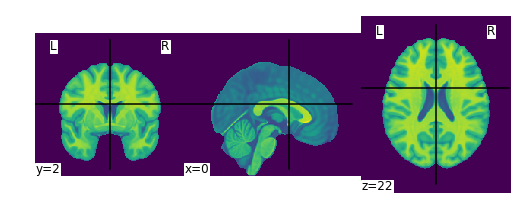

In [15]:
from nilearn import image, plotting
from nilearn.datasets import MNI152_FILE_PATH
smooth_anat_img = image.smooth_img(MNI152_FILE_PATH, fwhm=3)

# While we are giving a file name as input, the function returns
# an in-memory object:
plotting.plot_img(MNI152_FILE_PATH)

### Glass Brain Plots and Displaying the Subject $t$-statistic Maps

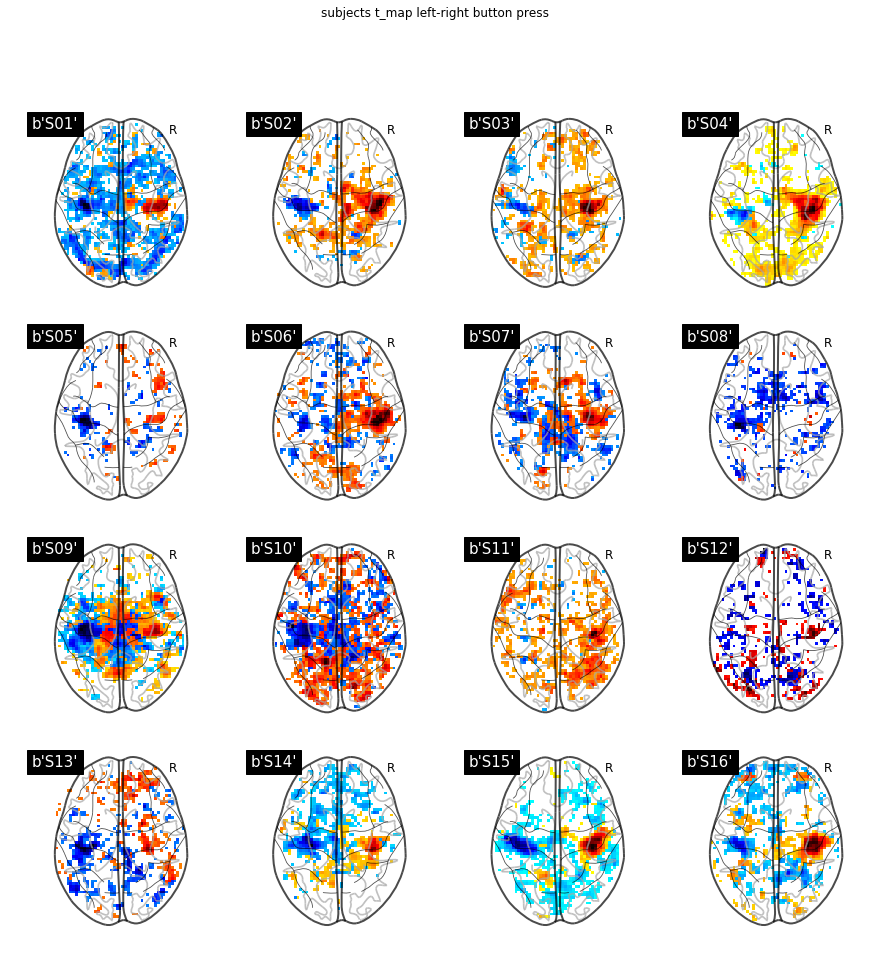

In [16]:
from nilearn import plotting

subjects = [subject_data[0] for subject_data in data['ext_vars']]
fig, axes = plt.subplots(nrows=4, ncols=4,figsize=(15,15))
for cidx, tmap in enumerate(data['tmaps']):
    plotting.plot_glass_brain(tmap, colorbar=False, threshold=2.0,
                              title=subjects[cidx],
                              axes=axes[int(cidx / 4), int(cidx % 4)],
                              plot_abs=False, display_mode='z')
fig.suptitle('subjects t_map left-right button press')
plt.show()

## Second-Level Analysis: Some Examples

So far we've downloaded some results from some first-level analyses. Now, let's have a look at how we can combine these at the second-level using `nilearn`!

### A simple design

In [17]:
second_level_input = data['cmaps']
design_matrix = pd.DataFrame([1] * len(second_level_input),
                             columns=['intercept'])

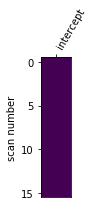

In [20]:
from nilearn.plotting import plot_design_matrix

# Create design matrix plot
plot_design_matrix(design_matrix)

# Show the plot
plt.show()

In [22]:
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel(smoothing_fwhm=8.0)
second_level_model = second_level_model.fit(second_level_input,
                                            design_matrix=design_matrix)

In [25]:
z_map = second_level_model.compute_contrast([1],output_type='z_score')

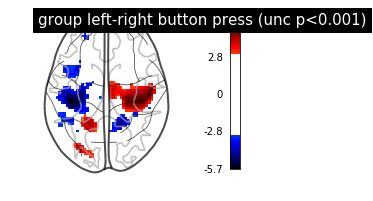

In [26]:
from scipy.stats import norm
p_val = 0.001
p001_unc = norm.isf(p_val)
display = plotting.plot_glass_brain(
    z_map, threshold=p001_unc, colorbar=True, display_mode='z', plot_abs=False,
    title='group left-right button press (unc p<0.001)')
plotting.show()

### Non-Parametric Inference

In [30]:
import numpy as np
from nilearn.image import get_data, math_img

p_val = second_level_model.compute_contrast([1], output_type='p_value')
n_voxels = np.sum(get_data(second_level_model.masker_.mask_img_))
# Correcting the p-values for multiple testing and taking negative logarithm
neg_log_pval = math_img("-np.log10(np.minimum(1, img * {}))" #MARKER!!
                        .format(str(n_voxels)),
                        img=p_val)

<string>:1: RuntimeWarning: divide by zero encountered in log10


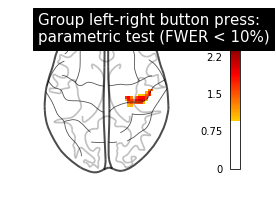

In [31]:
cut_coords = [0]
# Since we are plotting negative log p-values and using a threshold equal to 1,
# it corresponds to corrected p-values lower than 10%, meaning that there is
# less than 10% probability to make a single false discovery (90% chance that
# we make no false discovery at all).  This threshold is much more conservative
# than the previous one.
threshold = 1
title = ('Group left-right button press: \n'
         'parametric test (FWER < 10%)')
display = plotting.plot_glass_brain(
    neg_log_pval, colorbar=True, display_mode='z', plot_abs=False, vmax=3,
    cut_coords=cut_coords, threshold=threshold, title=title)
plotting.show()

In [29]:
from nilearn.glm.second_level import non_parametric_inference
neg_log_pvals_permuted_ols_unmasked = \
    non_parametric_inference(second_level_input,
                             design_matrix=design_matrix,
                             model_intercept=True, n_perm=1000,
                             two_sided_test=False,
                             smoothing_fwhm=8.0, n_jobs=1)


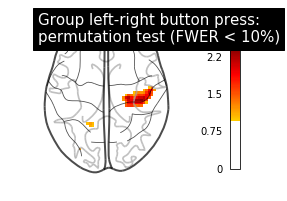

In [32]:
title = ('Group left-right button press: \n'
         'permutation test (FWER < 10%)')
display = plotting.plot_glass_brain(
    neg_log_pvals_permuted_ols_unmasked, colorbar=True, vmax=3,
    display_mode='z', plot_abs=False, cut_coords=cut_coords,
    threshold=threshold, title=title)
plotting.show()

In [33]:
# https://nilearn.github.io/auto_examples/05_glm_second_level/plot_second_level_one_sample_test.html#sphx-glr-auto-examples-05-glm-second-level-plot-second-level-one-sample-test-py

### Two-Sample Testing

In [34]:
n_subjects = 16
sample_vertical = fetch_localizer_contrasts(
    ["vertical checkerboard"], n_subjects, get_tmaps=True)
sample_horizontal = fetch_localizer_contrasts(
    ["horizontal checkerboard"], n_subjects, get_tmaps=True)

 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


In [35]:
second_level_input = sample_vertical['cmaps'] + sample_horizontal['cmaps']

In [36]:
import numpy as np
condition_effect = np.hstack(([1] * n_subjects, [- 1] * n_subjects))

In [37]:
subject_effect = np.vstack((np.eye(n_subjects), np.eye(n_subjects)))
subjects = [f'S{i:02d}' for i in range(1, n_subjects + 1)]

In [38]:
unpaired_design_matrix = pd.DataFrame(
    condition_effect[:, np.newaxis],
    columns=['vertical vs horizontal'])

paired_design_matrix = pd.DataFrame(
    np.hstack((condition_effect[:, np.newaxis], subject_effect)),
    columns=['vertical vs horizontal'] + subjects)

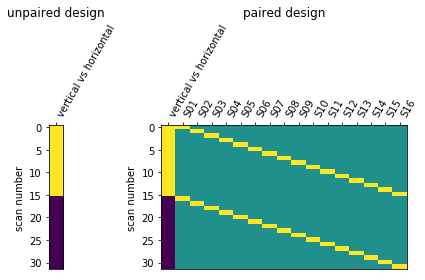

In [39]:
from nilearn.plotting import plot_design_matrix
_, (ax_unpaired, ax_paired) = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 17]})
plot_design_matrix(unpaired_design_matrix, rescale=False, ax=ax_unpaired)
plot_design_matrix(paired_design_matrix, rescale=False, ax=ax_paired)
ax_unpaired.set_title('unpaired design', fontsize=12)
ax_paired.set_title('paired design', fontsize=12)
plt.tight_layout()
plotting.show()

In [40]:
from nilearn.glm.second_level import SecondLevelModel

second_level_model_unpaired = SecondLevelModel().fit(
    second_level_input, design_matrix=unpaired_design_matrix)

second_level_model_paired = SecondLevelModel().fit(
    second_level_input, design_matrix=paired_design_matrix)

In [41]:
stat_maps_unpaired = second_level_model_unpaired.compute_contrast(
                                                    'vertical vs horizontal',
                                                    output_type='all')

stat_maps_paired = second_level_model_paired.compute_contrast(
                                                'vertical vs horizontal',
                                                output_type='all')

In [42]:
(stat_maps_unpaired['effect_size'].get_fdata()
    - stat_maps_paired['effect_size'].get_fdata()).max()

9.992007221626409e-16

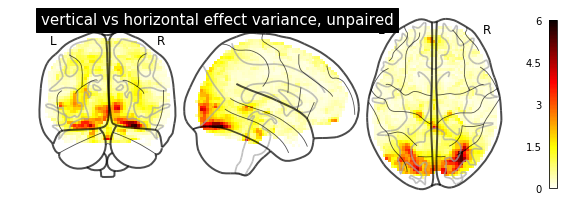

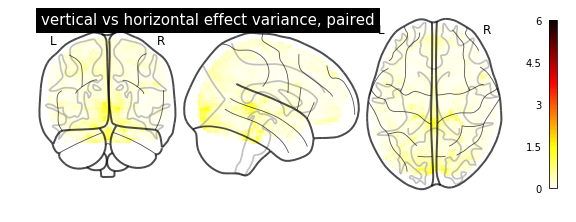

In [43]:
plotting.plot_glass_brain(
    stat_maps_unpaired['effect_variance'], colorbar=True, vmin=0, vmax=6,
    title='vertical vs horizontal effect variance, unpaired')

plotting.plot_glass_brain(
    stat_maps_paired['effect_variance'], colorbar=True, vmin=0, vmax=6,
    title='vertical vs horizontal effect variance, paired')

plotting.show()

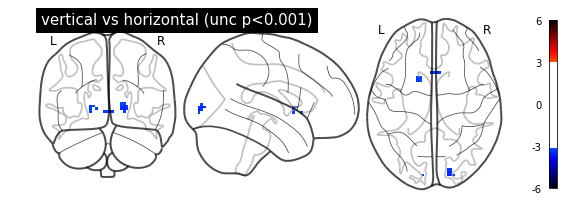

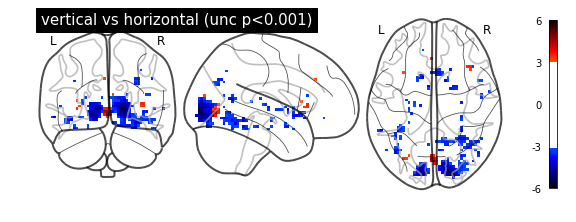

In [44]:
threshold = 3.1  # corresponds to  p < .001, uncorrected
display = plotting.plot_glass_brain(
    stat_maps_unpaired['z_score'], threshold=threshold, colorbar=True, plot_abs=False,
    title='vertical vs horizontal (unc p<0.001)', vmin=0, vmax=6)

display = plotting.plot_glass_brain(
    stat_maps_paired['z_score'], threshold=threshold, colorbar=True, plot_abs=False,
    title='vertical vs horizontal (unc p<0.001)', vmin=0, vmax=6)

plotting.show()

In [45]:
# https://nilearn.github.io/auto_examples/05_glm_second_level/plot_second_level_two_sample_test.html#sphx-glr-auto-examples-05-glm-second-level-plot-second-level-two-sample-test-py

### A More General Example

In [46]:
# https://nilearn.github.io/auto_examples/05_glm_second_level/plot_second_level_association_test.html#sphx-glr-auto-examples-05-glm-second-level-plot-second-level-association-test-py

# Exercises